In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


mpl.rcParams['figure.dpi']= 150

In [2]:
df = pd.read_csv('AASG_Thermed_AllTempsThicksConds.csv',low_memory=False)
# Drop 3 sigma outliers for HeatFlow
def outlierDrop(df,df_toCheck,std_cut_off):
    init_len = df.shape[0]
    for i in df_toCheck:
        mean = df[i].mean()
        std = df[i].std()
        cut_off = std * std_cut_off
        lower, upper =mean - cut_off, mean + cut_off
        df = df[(df[i] < upper) & (df[i] > lower)]
    print("numbere of outliers removed: ", init_len - df.shape[0])
    return df
df = outlierDrop(df,['HeatFlow'],3)
df = df[df['HeatFlow']>0]
df.reset_index(inplace=True, drop=True)

# Form X and Y
X = np.transpose(np.array([df.LatDegree,
                                df.LongDegree,
                                df.MeasureDepth_m,
                                df.SurfTemp]))
Y = df.CorrBHT.values
# Add Geological Layer information to X
layers = df.iloc[:,52:101].values
conds = df.iloc[:,101:150].values
mult = np.multiply(layers,conds)
np.nan_to_num(mult, 0)
X = np.concatenate((X, mult),axis=1)

numbere of outliers removed:  67


In [4]:
# load with pickle
import pickle
gbm = pickle.load(open('finalized_model_XGB.sav', 'rb'))

In [5]:
def oneRun(z_guess):
    # Read all data and merge
    thick_con_interpolated = []
    for i in range(0,49):
        temp_df = pd.read_csv('Mult'+str(i))
        # print(i, temp_df.iloc[:,2].values)
        thick_con_interpolated.append(temp_df.iloc[:,2].values)
    # Transpose to match the format
    thick_con_interpolated = np.transpose(np.array(thick_con_interpolated))
    df_interpolated = pd.DataFrame({'lat':temp_df.iloc[:,1].values,'lon':temp_df.iloc[:,0].values,
                                'z':np.full((len(temp_df.iloc[:,0].values),),z_guess),
                                't_surf':pd.read_csv('T_surf_knn').iloc[:,2].values}) # z is all z guess
    X_interpolated = np.concatenate((df_interpolated.values,thick_con_interpolated),axis=1)
    X_interpolated.shape
    xgb_pred = gbm.predict(X_interpolated)
    return xgb_pred

In [6]:
xgb_preds = []

for i in np.array(list(range(1,31)))*100:
    curr_pred = oneRun(i)
    xgb_preds.append(curr_pred)

In [7]:
gradients = []
rsq = []
for i in range(0, 28125):
    curr_preds = []
    for j in range(0, 30):
        curr_preds.append(xgb_preds[j][i])
    
    reg = LinearRegression().fit((np.array(list(range(1,31)))*100).reshape(-1,1),
                                 np.array(curr_preds))
    gradients.append(reg.coef_[0])
    rsq.append(reg.score((np.array(list(range(1,31)))*100).reshape(-1,1),
                                 np.array(curr_preds)))

In [8]:
df_t = pd.read_csv('Mult0')

In [9]:
gradients = np.array(gradients)*1000

Text(0.5, 1.0, 'Gradient Map with XGBoost')

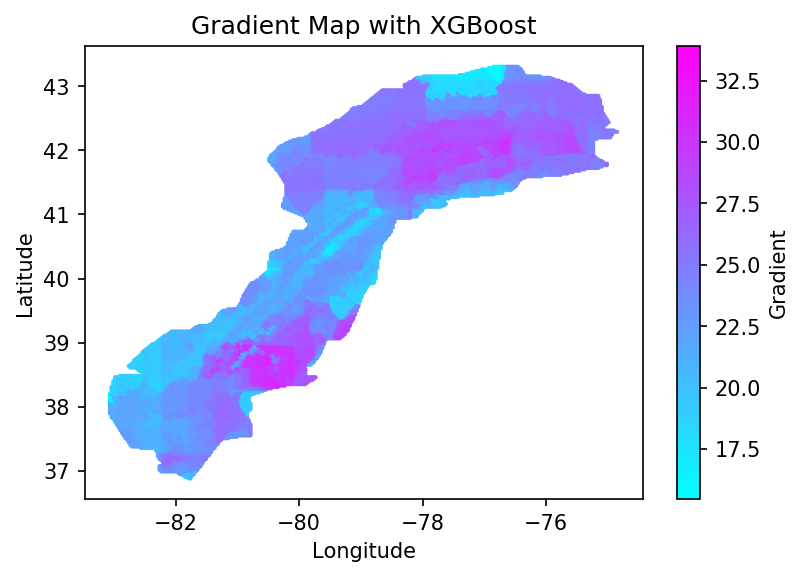

In [10]:
plt.scatter(df_t.long, df_t.lat, c=gradients, cmap='cool',s=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar().set_label('Gradient')
plt.title('Gradient Map with XGBoost')

In [11]:
df_t['grad'] = gradients
data = df_t


In [12]:
import folium
from folium.plugins import HeatMap
main_map = folium.Map(location = [42, -80],zoom_start=6, tiles='Stamen Terrain')
my_heat = HeatMap(data[['lat', 'long', 'grad']].to_numpy(),min_opacity =0, max_val = 10, overlay=True,blur =15)
my_heat.add_to(folium.FeatureGroup(name='Heat Map').add_to(main_map))
folium.LayerControl().add_to(main_map)
display(main_map)
main_map.save('index.html')

In [13]:
data_2 = data[data['grad']>27.5]

In [14]:
main_map = folium.Map(location = [42, -80],zoom_start=6)
my_heat = HeatMap(data_2[['lat', 'long', 'grad']].to_numpy(),min_opacity =0, max_val = 2, overlay=True,blur =13)
my_heat.add_to(folium.FeatureGroup(name='Heat Map').add_to(main_map))
folium.LayerControl().add_to(main_map)
main_map.fit_bounds(bounds = data_2[['lat', 'long']].values.tolist(), padding_bottom_right=(36,-82))
display(main_map)

(array([1.750e+02, 1.340e+03, 3.267e+03, 4.915e+03, 5.333e+03, 7.377e+03,
        3.806e+03, 1.616e+03, 2.920e+02, 4.000e+00]),
 array([15.45674257, 17.30135878, 19.14597499, 20.99059119, 22.8352074 ,
        24.67982361, 26.52443982, 28.36905602, 30.21367223, 32.05828844,
        33.90290464]),
 <a list of 10 Patch objects>)

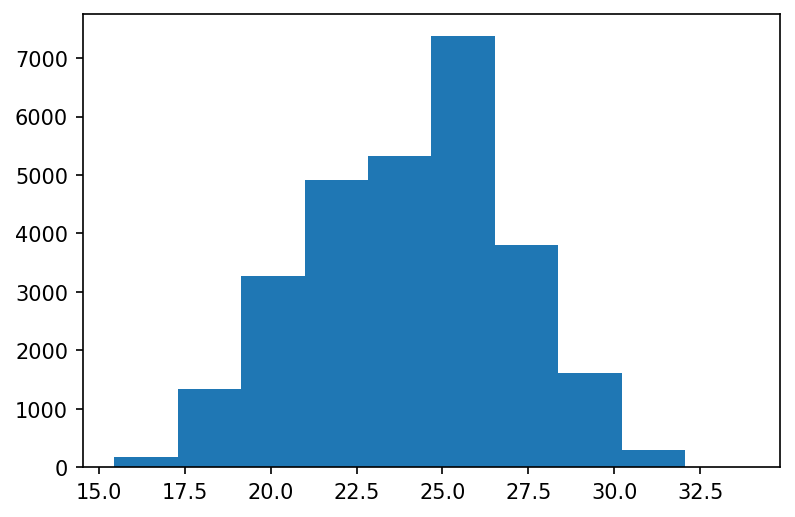

In [15]:
plt.hist(data['grad'])

In [16]:
data_2[['lat', 'long']].values.tolist()

[[38.286424153846156, -80.56490715217392],
 [38.286424153846156, -80.5371535],
 [38.286424153846156, -80.50939984782609],
 [38.286424153846156, -80.48164619565217],
 [38.286424153846156, -80.45389254347828],
 [38.308054307692316, -80.56490715217392],
 [38.308054307692316, -80.5371535],
 [38.308054307692316, -80.50939984782609],
 [38.308054307692316, -80.48164619565217],
 [38.308054307692316, -80.45389254347828],
 [38.308054307692316, -80.42613889130433],
 [38.308054307692316, -80.39838523913043],
 [38.308054307692316, -80.37063158695652],
 [38.308054307692316, -80.34287793478259],
 [38.32968446153846, -80.62041445652173],
 [38.32968446153846, -80.59266080434783],
 [38.32968446153846, -80.56490715217392],
 [38.32968446153846, -80.5371535],
 [38.32968446153846, -80.50939984782609],
 [38.32968446153846, -80.48164619565217],
 [38.32968446153846, -80.45389254347828],
 [38.32968446153846, -80.42613889130433],
 [38.32968446153846, -80.39838523913043],
 [38.32968446153846, -80.37063158695652],

In [17]:

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data['grad'].to_numpy().reshape(-1, 1))
data['grad'] = x_scaled

In [18]:
df_tt = pd.DataFrame({'rsq':rsq})
df_tt

,rsq
0,0.964668
1,0.963596
2,0.964458
3,0.964668
4,0.963473
...,...
28120,0.992977
28121,0.994597
28122,0.995022
28123,0.981640


In [19]:
data['grad']

0        0.216227
1        0.278212
2        0.219422
3        0.216227
4        0.242335
           ...   
28120    0.430186
28121    0.445034
28122    0.433217
28123    0.430293
28124    0.422144
Name: grad, Length: 28125, dtype: float64

In [20]:
data_2['grad'] = data_2['grad'].to_numpy()*10

/home/aryashahdi/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
min_opacity=min(data['grad'])

In [22]:
data

,long,lat,value,grad
0,-81.786068,36.880464,719.737074,0.216227
1,-81.758314,36.880464,761.684509,0.278212
2,-81.841575,36.902094,718.668212,0.219422
3,-81.813822,36.902094,719.120734,0.216227
4,-81.786068,36.902094,761.224374,0.242335
...,...,...,...,...
28120,-76.568381,43.304620,14.188725,0.430186
28121,-76.540628,43.304620,14.188538,0.445034
28122,-76.512874,43.304620,12.840721,0.433217
28123,-76.485120,43.304620,12.839609,0.430293
